# 해지 고객의 언더샘플링 이슈 해결

생존 분석을 위한 데이터에서 해지 고객의 언더샘플링 문제를 해결하고자 합니다. 

이를 위해 2023년의 해지 데이터를 기반으로 과거 기간의 해지 이벤트를 시뮬레이션하여 전체 데이터에 반영합니다. 즉, 2023년의 월별 해지 패턴이 2022년, 2021년 등 과거 연도에도 유사한 이탈율로 일어났다고 가정합니다. 이 때 가입 기간에 따른 비중도 반영합니다 (예. 24개월 째에 해지가 많은 패턴 반영 등).

이렇게 하면 과거 기간의 해지율을 보다 현실적으로 재현할 수 있습니다.

In [1]:
import warnings
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

## 1. 데이터 불러오기 및 전처리

In [2]:
data = pd.read_csv('team1/데이터검증_0925_2.csv')

# 날짜 형식으로 변환
data['FRST_ENTR_DT'] = pd.to_datetime(data['FRST_ENTR_DT'], format='%Y%m%d')
data['EXPRY_DT'] = pd.to_datetime(data['EXPRY_DT'], format='%Y%m%d', errors='coerce')

# 가입 기간(DURATION)을 월 단위로 계산
data['DURATION'] = ((data['EXPRY_DT'] - data['FRST_ENTR_DT']) / np.timedelta64(1, 'M')).round()

아래 해지한 고객 데이터 만을 추출합니다. 이를 통해 과거의 해지 패턴을 재생성할 것입니다.

In [3]:
# 해지한 고객 데이터 추출
churned_data = data[data['DURATION'].notnull()].copy()
churned_data['MONTH'] = churned_data['EXPRY_DT'].dt.month

## 2. 2023년 해지율 및 사용기한 별 해지 분포 계산

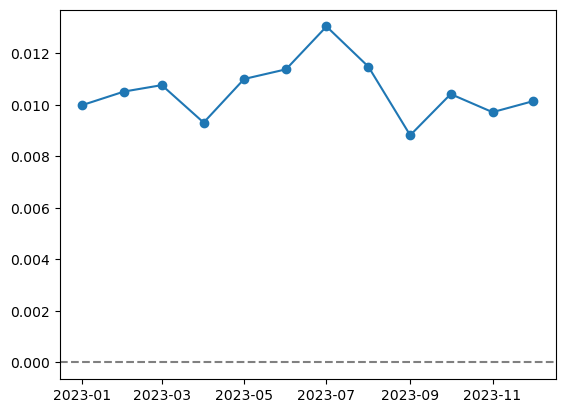

In [4]:
# 2023년 1월부터 12월까지의 월별 날짜 생성
date_list = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

churn_rate_list = []
churn_weight_list = []

for date in date_list:
    # 해당 월에 해지한 고객 추출
    churned_in_month = data[
        (data['EXPRY_DT'].notnull()) &
        (data['EXPRY_DT'] >= date) &
        (data['EXPRY_DT'] < date + relativedelta(months=1))
    ]
    # 가입 기간별 해지 수 계산
    churned_counts = churned_in_month.groupby('DURATION').size().reset_index(name='N')
    churned_counts = churned_counts.sort_values('DURATION')
    # 해당 월 시작 시점에서의 활성 고객 수 계산
    n_start = data[
        (data['FRST_ENTR_DT'] <= date) &
        ((data['EXPRY_DT'].isnull()) | (data['EXPRY_DT'] > date))
    ].shape[0]
    # 해지율 계산
    churn_rate = churned_counts['N'].sum() / n_start if n_start > 0 else 0
    churn_rate_list.append({'year_month': date.strftime('%Y-%m'), 'churn_rate': churn_rate})
    churned_counts['year_month'] = date.strftime('%Y-%m')
    churn_weight_list.append(churned_counts)

# 해지율 데이터프레임 생성
churn_df = pd.DataFrame(churn_rate_list)
churn_df['year_month'] = pd.to_datetime(churn_df['year_month'])

# 연월별 해지율 플롯
plt.plot(churn_df['year_month'], churn_df['churn_rate'], marker='o', linestyle='-', label='Churn Rate')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

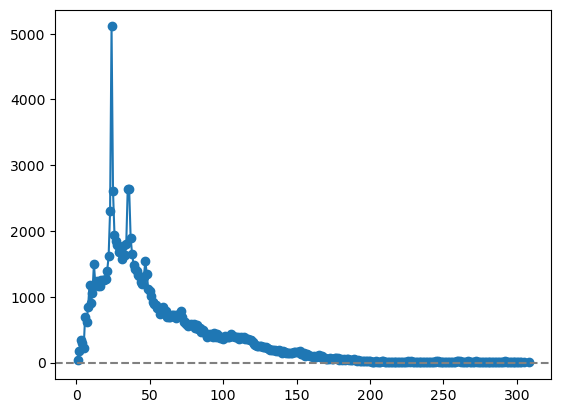

In [5]:
# 가입 기간별 해지 비율 계산
churn_weight_df = pd.concat(churn_weight_list)
churn_weight_df['DURATION'] = churn_weight_df['DURATION'].apply(lambda x: 1 if x == 0 else x)  # DURATION이 0인 경우 1로 변경
churn_weight_summ = churn_weight_df.groupby('DURATION')['N'].sum().reset_index()
churn_weight_summ['PERCENT'] = churn_weight_summ['N'] / churn_weight_summ['N'].sum()

# 가입 기간별 해지 수 플롯
plt.plot(churn_weight_summ['DURATION'], churn_weight_summ['N'], marker='o', linestyle='-', label='Number of Churns')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

## 3. 과거 기간의 활성 고객 수 계산

In [6]:
# 모든 가입 월 목록 생성
all_year_month = data['FRST_ENTR_DT'].dt.to_period('M').unique()
all_year_month = sorted(all_year_month)

n_start_list = []
for period in all_year_month:
    date = period.to_timestamp()
    n_start = data[
        (data['FRST_ENTR_DT'] <= date) &
        ((data['EXPRY_DT'].isnull()) | (data['EXPRY_DT'] > date))
    ].shape[0]
    n_start_list.append({'year_month': date.strftime('%Y-%m'), 'n_start': n_start})

n_start_df = pd.DataFrame(n_start_list)
n_start_df.head()

,year_month,n_start
0,1997-08,0
1,1997-09,5
2,1997-10,11
3,1997-11,36
4,1997-12,138


## 4. 예상 해지 수 계산 및 오차 보정

이렇게 해서 이탈을 시뮬레이션하는 경우에도 문제가 있습니다. 왜냐하면 특정 구간의 해지 고객이 이전 구간에서는 생존 고객으로 집계되기 때문입니다. 예를 들여, 2022년 1월 기준 5년 가입 후 해지한 고객은 2017~2021년 중에는 생존 고객으로 집계되기 때문입니다. 이 때문에 이탈율 곡선이 아래와 같이 점진적으로 커지는 것으로 나옵니다 (원래는 월 1% 정도에서 일정해야 합니다). 이를 보정하기 위해, 2022년 12월부터 역순으로 가면서 시점 별 초기 고객 규모를 구하고, 이에 따라 필요 해지 고객을 산출하는 로직입니다.

In [28]:
n_start_df2 = n_start_df.copy()

all_year_month_period = pd.PeriodIndex(all_year_month, freq='M')
all_dates_df = pd.DataFrame({'year_month': all_year_month_period.to_timestamp()})
n_start_df2['year_month'] = pd.to_datetime(n_start_df2['year_month'])
n_start_df2 = all_dates_df.merge(n_start_df2, on='year_month', how='left')
n_start_df2.set_index('year_month', inplace=True)

n_sample_ls = {}

for d in tqdm(reversed(all_year_month), total=len(all_year_month)):
    d_datetime = d.to_timestamp()
    n_start_orig = n_start_df2.loc[d_datetime, 'n_start']
    
    expected_churn_rate_row = churn_df.loc[churn_df['year_month'].dt.month == d.month, 'churn_rate']
    if not expected_churn_rate_row.empty:
        expected_churn_rate = expected_churn_rate_row.values[0]
    else:
        expected_churn_rate = 0  # 해당 월에 이탈율 정보가 없으면 0으로 설정
    expected_churn = n_start_orig * expected_churn_rate

    n_sample_df = churn_weight_summ.copy()
    n_sample_df['n_sample'] = n_sample_df['PERCENT'] * expected_churn

    n_sample_ls[d] = n_sample_df[['DURATION', 'n_sample']]
    
    to_add_list = []  # 이전 기간의 생존 고객 수를 조정하기 위한 데이터프레임 생성
    for idx, row in n_sample_df.iterrows():
        duration = int(row['DURATION'])
        n_sample = row['n_sample']
        if n_sample == 0 or duration == 0:
            continue
        gaps = pd.DataFrame({'gap': range(1, duration + 1)})
        gaps['year_month_alive'] = [d_datetime - relativedelta(months=gap) for gap in gaps['gap']]
        gaps['n_sample'] = n_sample
        to_add_list.append(gaps)

    if to_add_list:
        to_add_df = pd.concat(to_add_list, ignore_index=True)
        to_add_df = to_add_df.groupby('year_month_alive', as_index=False)['n_sample'].sum()
        to_add_df.set_index('year_month_alive', inplace=True)
        
        for date, row in to_add_df.iterrows():
            if date in n_start_df2.index:
                n_start_df2.loc[date, 'n_start'] += row['n_sample']
            else:
                n_start_df2.loc[date] = {'n_start': row['n_sample']}
    
        n_start_df2.sort_index(inplace=True)

sample_n_df2 = pd.concat(n_sample_ls.values(), keys=n_sample_ls.keys(), names=['year_month']).reset_index()
sample_n_df2['year_month'] = sample_n_df2['year_month'].apply(lambda x: x.to_timestamp())
sample_n_df2

100%|██████████| 305/305 [11:29<00:00,  2.26s/it]


,year_month,level_1,DURATION,n_sample
0,2022-12-01,0,1.0,3.879066
1,2022-12-01,1,2.0,15.010299
2,2022-12-01,2,3.0,28.334047
3,2022-12-01,3,4.0,24.539309
4,2022-12-01,4,5.0,18.467727
...,...,...,...,...
93020,1997-08-01,300,301.0,0.024216
93021,1997-08-01,301,302.0,0.064577
93022,1997-08-01,302,303.0,0.008072
93023,1997-08-01,303,305.0,0.008072


In [40]:
# Sanity check
churn_df_check = pd.merge(
    n_start_df2.reset_index(), 
    sample_n_df2.groupby('year_month')['n_sample'].sum().reset_index(), 
    on='year_month', how='left')
churn_df_check = churn_df_check[churn_df_check['year_month'] >= all_dates_df['year_month'][0]]
churn_df_check['churn_rate'] = churn_df_check['n_sample'] / churn_df_check['n_start']
churn_df_check

,year_month,n_start,n_sample,churn_rate
308,1997-08-01,8.396315e+04,964.016167,0.011481
309,1997-09-01,8.493204e+04,748.965670,0.008818
310,1997-10-01,8.577366e+04,893.421479,0.010416
311,1997-11-01,8.670023e+04,842.189425,0.009714
312,1997-12-01,8.767369e+04,889.078335,0.010141
...,...,...,...,...
608,2022-08-01,1.000250e+06,11484.286774,0.011481
609,2022-09-01,9.996769e+05,8815.562451,0.008818
610,2022-10-01,9.967336e+05,10382.012957,0.010416
611,2022-11-01,9.957688e+05,9672.707535,0.009714


In [52]:
# Sanity check
sample_n_df2.groupby('DURATION')['n_sample'].sum().reset_index()

,DURATION,n_sample
0,1.0,589.223503
1,2.0,2280.038771
2,3.0,4303.893411
3,4.0,3727.479115
4,5.0,2805.216241
...,...,...
300,301.0,38.427620
301,302.0,102.473653
302,303.0,12.809207
303,305.0,12.809207


In [41]:
def distribute_rounding_remainder(df):
    df = df.copy()
    df['year'] = pd.to_datetime(df['year_month']).dt.year
    
    df['n_sample_round'] = df['n_sample'].round()
    df['remainder'] = df['n_sample'] - df['n_sample_round']
    
    df_list = []
    for year, group in df.groupby('year'):
        group_sorted = group.sort_values(by=['year_month', 'DURATION']).reset_index(drop=True)
        adjusted_group = redistribute_within_year(group_sorted)
        df_list.append(adjusted_group)
    
    df_result = pd.concat(df_list, ignore_index=True)
    df_result = df_result[df_result['n_sample_round'] > 0].reset_index(drop=True)
    return df_result

def redistribute_within_year(df):
    df = df.copy()
    overage_cells = df[df['remainder'] < 0].reset_index()
    for i in range(len(overage_cells)):
        overage_idx = overage_cells.loc[i, 'index']  # df 내에서의 인덱스
        remainder_to_distribute = abs(overage_cells.loc[i, 'remainder'])
        if overage_idx > 0 and remainder_to_distribute > 0:
            left_idx = overage_idx - 1
            if df.loc[left_idx, 'year'] == df.loc[overage_idx, 'year']:
                df.loc[left_idx, 'n_sample_round'] += remainder_to_distribute
        elif overage_idx < len(df) - 1 and remainder_to_distribute > 0:
            right_idx = overage_idx + 1
            if df.loc[right_idx, 'year'] == df.loc[overage_idx, 'year']:
                df.loc[right_idx, 'n_sample_round'] += remainder_to_distribute
    df['n_sample_round'] = df['n_sample_round'].round().astype(int)
    return df

sample_n_df3 = distribute_rounding_remainder(sample_n_df2)
sample_n_df3

,year_month,level_1,DURATION,n_sample,year,n_sample_round,remainder
0,1997-08-01,1,2.0,1.436842,1997,1,0.436842
1,1997-08-01,2,3.0,2.712241,1997,3,-0.287759
2,1997-08-01,3,4.0,2.348995,1997,2,0.348995
3,1997-08-01,4,5.0,1.767800,1997,2,-0.232200
4,1997-08-01,5,6.0,5.602070,1997,6,-0.397930
...,...,...,...,...,...,...,...
67964,2022-12-01,293,294.0,0.927603,2022,1,-0.072397
67965,2022-12-01,294,295.0,0.590293,2022,1,-0.409707
67966,2022-12-01,295,296.0,0.505965,2022,1,-0.494035
67967,2022-12-01,297,298.0,0.927603,2022,1,-0.072397


In [58]:
# Sanity check
churn_df_check2 = pd.merge(
    n_start_df2.reset_index(), 
    sample_n_df3.groupby('year_month')['n_sample_round'].sum().reset_index(), 
    on='year_month', how='left')
churn_df_check2 = churn_df_check2[churn_df_check2['year_month'] >= all_dates_df['year_month'][0]]
churn_df_check2['churn_rate'] = churn_df_check2['n_sample_round'] / churn_df_check2['n_start'].round()
churn_df_check2

,year_month,n_start,n_sample_round,churn_rate
308,1997-08-01,8.396315e+04,952.0,0.011338
309,1997-09-01,8.493204e+04,733.0,0.008630
310,1997-10-01,8.577366e+04,878.0,0.010236
311,1997-11-01,8.670023e+04,835.0,0.009631
312,1997-12-01,8.767369e+04,873.0,0.009957
...,...,...,...,...
608,2022-08-01,1.000250e+06,11489.0,0.011486
609,2022-09-01,9.996769e+05,8809.0,0.008812
610,2022-10-01,9.967336e+05,10377.0,0.010411
611,2022-11-01,9.957688e+05,9666.0,0.009707


In [59]:
# Sanity check
sample_n_df3.groupby('DURATION')['n_sample_round'].sum().reset_index()

,DURATION,n_sample_round
0,1.0,590
1,2.0,2283
2,3.0,4301
3,4.0,3724
4,5.0,2803
...,...,...
280,295.0,71
281,296.0,37
282,298.0,121
283,300.0,4


## 5. 해지 이벤트 시뮬레이션

In [82]:
sampled_list = []

# sample_n_df3_test = sample_n_df3.head(600)
# for idx, row in sample_n_df3_test.iterrows():
for idx, row in tqdm(sample_n_df3.iterrows(), total=len(sample_n_df3)):
    duration = row['DURATION']
    n_samples = int(row['n_sample_round'])
    year_month = row['year_month']
    
    # 해당 가입 기간의 해지 고객에서 샘플링
    available_churns = churned_data[churned_data['DURATION'] == duration]
    if available_churns.empty or n_samples == 0:
        continue
    
    sampled = available_churns.sample(n=n_samples, replace=True, random_state=42)
    
    # 날짜 조정
    set_year_month = pd.to_datetime(year_month)
    
    # 총 개월 수 차이 계산
    months_diff = (sampled['EXPRY_DT'].dt.year - set_year_month.year) * 12 + \
                  (sampled['EXPRY_DT'].dt.month - set_year_month.month)
    
    # EXPRY_DT와 FRST_ENTR_DT를 총 개월 수만큼 조정
    sampled['EXPRY_DT'] = sampled['EXPRY_DT'] - months_diff.apply(lambda x: pd.DateOffset(months=x))
    sampled['FRST_ENTR_DT'] = sampled['FRST_ENTR_DT'] - months_diff.apply(lambda x: pd.DateOffset(months=x))
    
    # 필요 없는 컬럼 제거
    sampled = sampled.drop(columns=['DURATION', 'MONTH'])
    sampled_list.append(sampled)

100%|██████████| 67969/67969 [12:06<00:00, 93.62it/s]  


## 6. 최종 데이터 결합

In [95]:
simulated_churn_data = pd.concat(sampled_list, ignore_index=True)
data['_simulated'] = 'original'
simulated_churn_data['_simulated'] = 'simulated'
final_data = pd.concat([data, simulated_churn_data], ignore_index=True)

In [96]:
final_data.to_csv('team1/데이터검증_0925_3.csv', index=False, encoding='utf-8-sig')

## 7. Sanity check

In [85]:
check_data = simulated_churn_data.copy()
check_data['DURATION'] = ((check_data['EXPRY_DT'] - check_data['FRST_ENTR_DT']) / np.timedelta64(1, 'M')).round()

In [86]:
check_data_summ = check_data['DURATION'].value_counts().reset_index().sort_values(by='DURATION')
check_data_summ

,DURATION,count
183,1.0,590
134,2.0,2353
115,3.0,4100
118,4.0,3513
122,5.0,3168
...,...,...
286,297.0,2
231,298.0,121
285,300.0,4
265,302.0,57


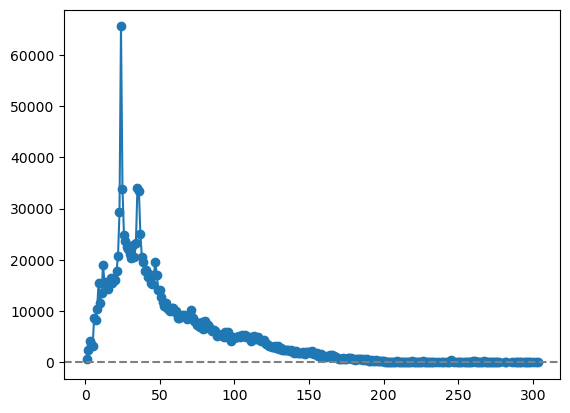

In [87]:
plt.plot(check_data_summ['DURATION'], check_data_summ['count'], marker='o', linestyle='-', label='Number of Churns')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

In [88]:
check_data2 = final_data.copy()

In [89]:
churn_rate2_list = []

for date in all_year_month:
    date_start = date.to_timestamp()  # Period -> datetime 변환
    date_end = (date_start + relativedelta(months=1))  # datetime에 relativedelta 적용

    n_start = check_data2[
        (check_data2['FRST_ENTR_DT'] <= date_start) &
        ((check_data2['EXPRY_DT'].isnull()) | (check_data2['EXPRY_DT'] > date_start))
    ].shape[0]

    n_churn = check_data2[
        (check_data2['EXPRY_DT'].notnull()) &
        (check_data2['EXPRY_DT'] >= date_start) &
        (check_data2['EXPRY_DT'] < date_end)
    ].shape[0]

    churn_rate = n_churn / n_start if n_start > 0 else 0
    churn_rate2_list.append({'year_month': date.strftime('%Y-%m'), 'churn_rate': churn_rate, 'n_start': n_start, 'n_churn': n_churn})

churn_df2 = pd.DataFrame(churn_rate2_list)

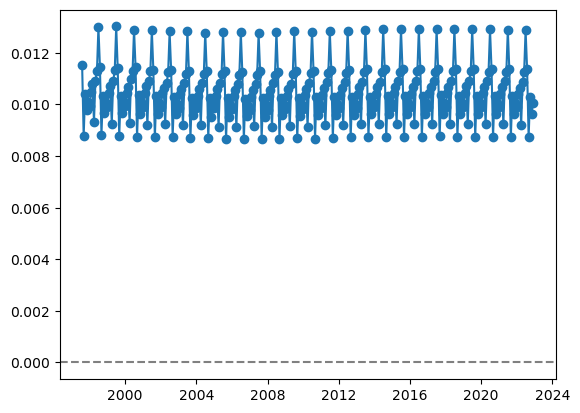

In [90]:
churn_df2['year_month'] = pd.to_datetime(churn_df2['year_month'])
plt.plot(churn_df2['year_month'], churn_df2['churn_rate'], marker='o', linestyle='-', label='Churn Rate')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

In [92]:
from lifelines import KaplanMeierFitter

def check_survival_curve(df):
    df = df.sample(n=100000, random_state=42) if len(df) > 100000 else df

    df['FRST_ENTR_DT'] = pd.to_datetime(df['FRST_ENTR_DT'])
    df['EXPRY_DT'] = pd.to_datetime(df['EXPRY_DT'])
    df['DURATION'] = ((df['EXPRY_DT'] - df['FRST_ENTR_DT']) / np.timedelta64(1, 'M')).round()
    df['EVENT'] = (~df['EXPRY_DT'].isna()).astype(int)
    end_date = pd.Timestamp('2023-12-31')
    df['DURATION2'] = ((end_date - df['FRST_ENTR_DT']) / np.timedelta64(1, 'M')).round()
    df['DURATION'] = df['DURATION'].fillna(df['DURATION2'])
    df = df.drop('DURATION2', axis=1)

    # 생존곡선 그리기
    kmf = KaplanMeierFitter()
    kmf.fit(durations=df['DURATION'], event_observed=df['EVENT'])
    kmf.plot_survival_function()
    plt.ylim(0, 1)
    plt.xlim(0, 120)
    plt.title('Kaplan-Meier Survival Curve (n=100000)')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.show()

수정 전 생존 곡선

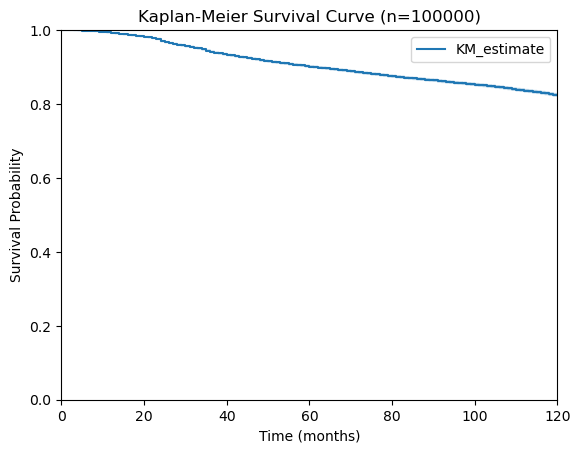

In [93]:
check_survival_curve(data)

수정 후 생존 곡선

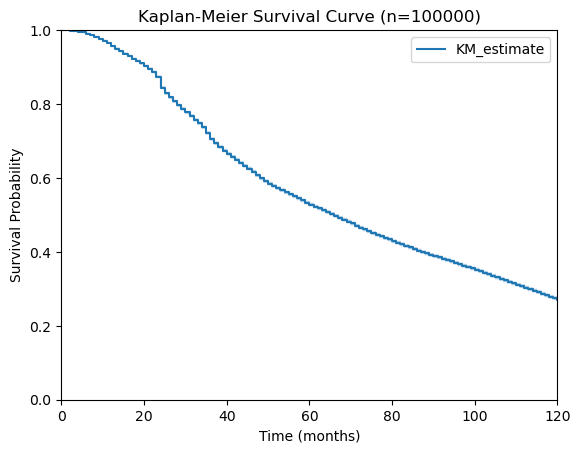

In [94]:
check_survival_curve(final_data)